# COMP 5318 - Machine Learning and Data Mining: Assignment 1

 A1.1-Group 14

 Ziyin Hu 
 
 Jiawei Yang 

## Information

Our ML models

1. Nearest Neighbor 
2. Logistic Regression 
3. Decision Tree 

and ONE ensemble method:

4. Bagging (LightGBM)

## 1 Environment Setup

Install and import necessary packages and libraries used in your coding environment. It is recommended to specify their versions to ensure reproducibility.

Hardware1: Dell Laptop RAM:32G ROM:2T CPU:14 Core GPU Ada2000 8G

Hardware2: MacBook Pro RAM:16G ROM:1T CPU:14 Core 

Python Version : 3.8.19

Packages : 

In [ ]:
# Install and import necessary libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.linear_model import LogisticRegression
# For accuracy_score, classification_report and confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# To make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline

Define any necessary utility or helper functions (e.g., for plotting, optimization, etc.) if applicable.

## 2 Data Preprocessing

Implement at least ONE preprocessing technique on the dataset before model training. Possible methods include **Normalization**, **Dimensionality Reduction**, etc.

In [2]:
# Implement Preprocessing Techniques
data_train_df = pd.read_csv('./data/train.csv') # use
data_test_df = pd.read_csv('./data/test2.csv')  # use
data_test1_df = pd.read_csv('./data/test1.csv')
data_sample_df = pd.read_csv('./data/sample.csv')
data_train_df.head()

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v776,v777,v778,v779,v780,v781,v782,v783,v784,label
0,1,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,6
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,3,0,0,0,0,0,0,0,1,1,...,7,1,0,0,0,0,0,0,0,4
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


- 1. Normalization
- 2. PCA

In [ ]:
# Normalise data
# train
X_train = data_train_df.loc[:, "v1":"v784"].to_numpy()
y_train = data_train_df.label.to_numpy()
# test
X_test = data_test_df.loc[:, "v1":"v784"].to_numpy()

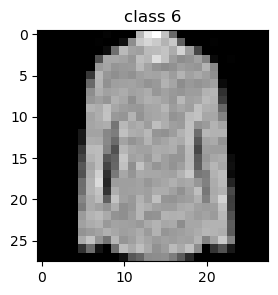

In [4]:
image = X_train.reshape((X_train.shape[0], 28, 28)) # 28x28 -> image
plt.figure(figsize=(3,3))
plt.imshow(image[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(y_train[0]))
plt.show()

In [5]:
# Dimensionality Reduction using Principal Component Analysis
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_minmax = scaler.transform(X_train)
X_test_minmax = scaler.transform(X_test)

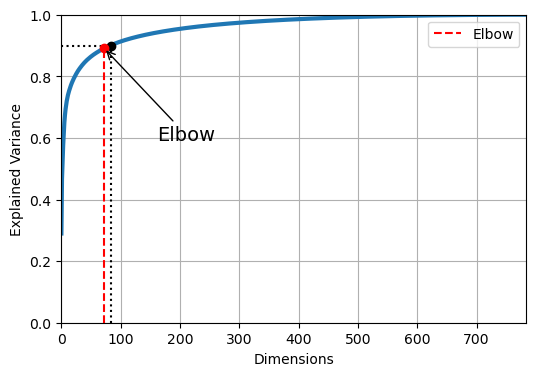

Elbow point is at Principal Component: 72
Explained Variance at Elbow: 0.8909


In [ ]:
pca = PCA()
# Fit PCA to the training dataset
pca.fit(X_train)
# Calculate the cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
# Find the minimum dimension d for which the cumulative explained variance exceeds 90%
d = np.argmax(cumsum >= 0.90) + 1
# Automatically find the Elbow point (where the curve starts to flatten)
# Use the first-order difference method to identify the point with the largest change in explained variance
diffs = np.diff(cumsum) # Calculate the rate of change in variance between adjacent principal components
elbow = np.argmax(diffs < 0.001) + 1  # elbow : when the difference in the rate of change falls below a certain threshold

# Plot the cumulative explained variance curve
plt.figure(figsize=(6, 4))

# Plot the cumulative explained variance
plt.plot(cumsum, linewidth=3)
plt.axis([0, len(cumsum), 0, 1])


plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

# 90%
plt.plot([d, d], [0, 0.90], "k:")
plt.plot([0, d], [0.90, 0.90], "k:")
plt.plot(d, 0.90, "ko")

# draw Elbow point
plt.plot([elbow, elbow], [0, cumsum[elbow]], "r--", label="Elbow")
plt.plot(elbow, cumsum[elbow], "ro")  # mark


plt.annotate("Elbow", xy=(elbow, cumsum[elbow]), xytext=(elbow + 90, cumsum[elbow] - 0.3),
             arrowprops=dict(arrowstyle="->"), fontsize=14)

plt.grid(True)
plt.legend()
plt.savefig("explained_variance_plot_with_elbow.png")
plt.show()

print(f"Elbow point is at Principal Component: {elbow}")
print(f"Explained Variance at Elbow: {cumsum[elbow]:.4f}")

In [7]:
pca = PCA(n_components= elbow) # elbow here is 72
pca.fit(X_train_minmax)
X_train_pca = pca.transform(X_train_minmax)
X_test_pca = pca.transform(X_test_minmax)
print("Original Dataset: ","X_train ",X_train.shape," X_test ",X_test.shape)
print("After PCA: ","X_train_pca ",X_train_pca.shape," X_test_pca ",X_test_pca.shape)

Original Dataset:  X_train  (30000, 784)  X_test  (5000, 784)
After PCA:  X_train_pca  (30000, 72)  X_test_pca  (5000, 72)


## 3 Models

### 3.1 KNN

#### Implementation

In [ ]:
param_grid_knn={'p':[1,2],
                'n_neighbors':[3,5,7],
                'algorithm': ['auto', 'kd_tree'],
                }
grid_search_knn= GridSearchCV(KNeighborsClassifier(),param_grid_knn,cv = 2, verbose=1) #
grid_search_knn.fit(X_train_pca,y_train)
# 3m

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2]},
             verbose=1)

#### Hyper-parameters Tuning

In [ ]:
param_grid_knn={
                'p':[1, 2],
                'n_neighbors':[3,5,7,9,11,13,15],
                'algorithm': ['auto'],
                'leaf_size': [5, 10, 20, 30, 50]
                }

grid_search_knn= GridSearchCV(KNeighborsClassifier(),
                              param_grid_knn,
                              cv = 10,
                              verbose=1,
                              n_jobs=-1) #
grid_search_knn.fit(X_train_pca,y_train)
# < 5m    0.856

Fitting 10 folds for each of 70 candidates, totalling 700 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'leaf_size': [5, 10, 20, 30, 50],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             verbose=1)

In [10]:
knn_accuracy = []
knn_time = []
index_ = 0
# nested for loop : outside: n_neighbors (inside: p)
# collect mean_test_score & mean_fit_time+mean_score_time
for i in range(len(param_grid_knn['n_neighbors'])):
    temp_accuracy = []
    temp_time = []
    for j in range(len(param_grid_knn['p'])):
        temp_accuracy.append(grid_search_knn.cv_results_['mean_test_score'][index_]*100)
        temp_time.append(grid_search_knn.cv_results_['mean_fit_time'][index_]
                         +grid_search_knn.cv_results_['mean_score_time'][index_])
        index_ += 1
    knn_accuracy.append(temp_accuracy)
    knn_time.append(temp_time)
# prepare for plotting
knn_accuracy = np.array(knn_accuracy).T
knn_time = np.array(knn_time).T

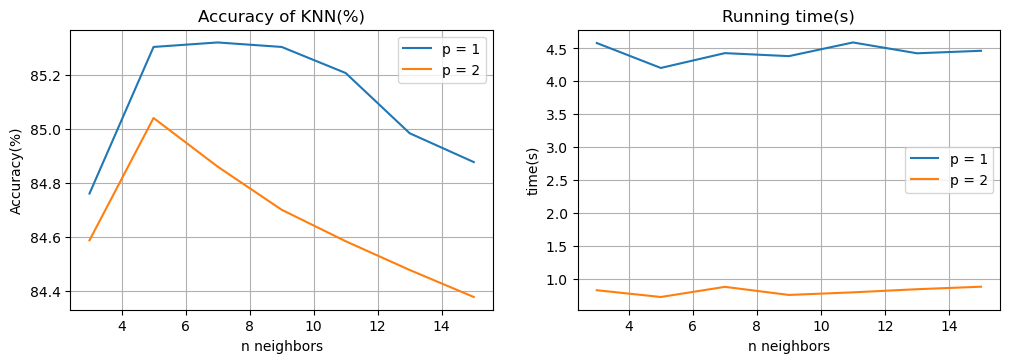

In [11]:
# accuracy, runtime
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(param_grid_knn['n_neighbors'],knn_accuracy[0])
plt.plot(param_grid_knn['n_neighbors'],knn_accuracy[1])
plt.legend(["p = 1", "p = 2"])
plt.title("Accuracy of KNN(%)")
plt.ylabel("Accuracy(%)")
plt.xlabel("n neighbors")
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(param_grid_knn['n_neighbors'],knn_time[0])
plt.plot(param_grid_knn['n_neighbors'],knn_time[1])
plt.legend(["p = 1", "p = 2"])
plt.title("Running time(s)")
plt.ylabel("time(s)")
plt.xlabel("n neighbors")
plt.grid(True)

plt.show()

In [ ]:
# Output the best parameters
print("Best parameters:", grid_search_knn.best_params_)
print("Best score:", grid_search_knn.best_score_)
best_KNN = grid_search_knn.best_estimator_

Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 7, 'p': 1}
Best score: 0.8532


### 3.2 Decision Tree

#### Implementation

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid_dtc = {
                'max_depth': [3],
                'min_samples_split': [2],
                'min_samples_leaf': [1],
                 #'criterion': ['gini', 'entropy']
                }
grid_search_dtc = GridSearchCV(DecisionTreeClassifier(),param_grid_dtc,cv=2,verbose=1)
grid_search_dtc.fit(X_train_pca, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3], 'min_samples_leaf': [1],
                         'min_samples_split': [2]},
             verbose=1)

#### Hyper-parameters Tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid_dtc = {
                'max_depth': [None,11, 13, 15, 17],
                'min_samples_split': [5, 7, 9, 11],
                'min_samples_leaf': [8, 10, 12, 14, 16],
                'max_features': [None, 'sqrt', 'log2'],
                'criterion': ['entropy', 'gini']
                }
grid_search_dtc = GridSearchCV(DecisionTreeClassifier(),param_grid_dtc,cv=10,verbose=1,n_jobs=-1)
grid_search_dtc.fit(X_train_pca, y_train)
# 10m

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 11, 13, 15, 17],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [8, 10, 12, 14, 16],
                         'min_samples_split': [5, 7, 9, 11]},
             verbose=1)

In [15]:
print("Best parameters:", grid_search_dtc.best_params_)
print("Best score:", grid_search_dtc.best_score_)
best_DTC = grid_search_dtc.best_estimator_

Best parameters: {'criterion': 'entropy', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 7}
Best score: 0.7747333333333333


### 3.3 Logistic Regression

#### Implementation

In [ ]:
param_grid_logistic = {
    'C': [1],
    'max_iter': [1000]
}
grid_search_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic,cv=2,n_jobs=-1)
grid_search_logistic.fit(X_train_pca, y_train)
# 15s

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1], 'max_iter': [1000]})

#### Hyper-parameters Tuning

In [ ]:
"""
We found that grid search requires substantial computational resources.
After reviewing the literature, we decided to start experimenting with Bayesian optimization.
"""
# Define the parameter search space for Bayesian optimization
search_spaces = {
    'C': (1e4, 1e6, 'log-uniform'),
    'penalty': ['l2'],
     'max_iter': (1500, 3000),
    'class_weight': [None, 'balanced']

}

# Initialize the Bayesian search
bayes_search_logistic = BayesSearchCV(
    LogisticRegression(),
    search_spaces,
    n_iter=20,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
bayes_search_logistic.fit(X_train_pca, y_train)
# 17m 0.8399

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

d:\Environment\miniconda_base\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BayesSearchCV(cv=10, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'C': (10000.0, 1000000.0, 'log-uniform'),
                             'class_weight': [None, 'balanced'],
                             'max_iter': (1500, 3000), 'penalty': ['l2']},
              verbose=1)

In [18]:
print("Best Parameters:", bayes_search_logistic.best_params_)
print("Best Score:", bayes_search_logistic.best_score_)
best_Logistic = bayes_search_logistic.best_estimator_

Best Parameters: OrderedDict([('C', 192261.55482744437), ('class_weight', 'balanced'), ('max_iter', 2031), ('penalty', 'l2')])
Best Score: 0.8399666666666666


### 3.4 Boosting GBDT(LightGBM)

#### Implementation

In [ ]:
search_spaces = {
    'n_estimators': [450],
    'max_depth': [8],
    'learning_rate': [0.1],
    'num_leaves': [126],
    'min_data_in_leaf': [45],
    'device':['gpu']
}
bayes_search_lgb = BayesSearchCV(
    lgb.LGBMClassifier(),
    search_spaces,
    n_iter=3,
    cv=2,
    scoring='accuracy',
    # verbose=1,
    n_jobs=-1
)
bayes_search_lgb.fit(X_train_pca, y_train)
# 4m

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 72
[LightGBM] [Info] Using GPU Device: NVIDIA RTX 2000 Ada Generation Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 72 dense feature groups (2.06 MB) transferred to GPU in 0.007614 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -2.317022
[LightGBM] [Info] Start training from score -2.288682
[LightGBM] [Info] Start training from score -2.307263
[LightGBM] [Info] Start training from score -2.3

BayesSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=3, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'device': ['gpu'], 'learning_rate': [0.1],
                             'max_depth': [8], 'min_data_in_leaf': [45],
                             'n_estimators': [450], 'num_leaves': [126]})

#### Hyper-parameters Tuning

In [ ]:
"""
records
1  34m
Best Parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.1530730659096197),
('max_depth', 7), ('min_data_in_leaf', 40), ('n_estimators', 300), ('num_leaves', 127)])
Best Score: 0.881
2  17m
Best Parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.13836121975869622),
('max_depth', 7), ('min_data_in_leaf', 38), ('n_estimators', 387), ('num_leaves', 125)])
Best Score: 0.8789999999999999
3
Best Parameters: OrderedDict([('learning_rate', 0.14466268680514088), ('max_depth', 8),
('min_data_in_leaf', 44), ('n_estimators', 444), ('num_leaves', 126)])
Best Score: 0.8818333333333334
5
Best parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.09218530252203186),
('max_depth', 7), ('min_data_in_leaf', 39), ('n_estimators', 476), ('num_leaves', 147),
('subsample', 0.9043547509490489)])
Best score: 0.8789333333333333
"""
search_spaces = {
    'n_estimators': (300, 500),
    'max_depth': (5,9),
    'learning_rate': (0.01, 0.2),
    'num_leaves': (100,300),
    'min_data_in_leaf':(30,50),
    'device':['gpu']
}

bayes_search_lgb = BayesSearchCV(
    lgb.LGBMClassifier(),
    search_spaces,
    n_iter=20,
    cv=10,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
    )
bayes_search_lgb.fit(X_train_pca, y_train)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=10, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
              scoring='accuracy',
              search_spaces={'device': ['gpu'], 'learning_rate': (0.01, 0.2),
                             'max_depth': (5, 9), 'min_data_in_leaf': (30, 50),
                             'n_estimators': (300, 500),
                             'num_leaves': (100, 300)},
              verbose=2)

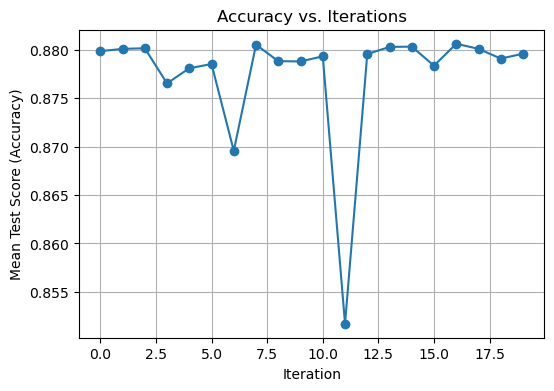

In [21]:
# After training the Bayesian search, retrieve the results of each iteration
results = pd.DataFrame(bayes_search_lgb.cv_results_)
plt.figure(figsize=(6,4))
plt.plot(results.index, results['mean_test_score'], marker='o')
plt.title('Accuracy vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score (Accuracy)')
plt.grid(True)
plt.show()

In [23]:
print("Best parameters:", bayes_search_lgb.best_params_)
print("Best score:", bayes_search_lgb.best_score_)
best_GBDT = bayes_search_lgb.best_estimator_

Best parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.2), ('max_depth', 6), ('min_data_in_leaf', 30), ('n_estimators', 500), ('num_leaves', 100)])
Best score: 0.8806333333333333


## 4 Evaluation and Comparison

Compare all classifiers with their optimized hyper-parameters, focusing on criteria such as classification performance, training time, and inference time. Visualization of these comparisons is required; use high-quality plots, figures, or tables to facilitate a clear understanding of the differences and strengths of each model.

In [31]:
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train_pca,y_train, test_size = 0.2, random_state=42)
start_knn = time.time()
best_KNN.fit(X_train_split, y_train_split)
print("Best KNN:\nAccuracy = %.2f%%\ttime:%.2fs" %(best_KNN.score(X_valid,y_valid)*100,
                                                  time.time()-start_knn))

start_svm = time.time()
best_DTC.fit(X_train_split, y_train_split)
print("Best SVM:\nAccuracy = %.2f%%\ttime:%.2fs" %(best_DTC.score(X_valid,y_valid)*100,
                                                  time.time()-start_svm))
start_logistic = time.time()
best_Logistic.fit(X_train_split, y_train_split)
print("Best Logistic Regression:\nAccuracy = %.2f%%\ttime:%.2fs" %(best_Logistic.score(X_valid,y_valid)*100,
                                                  time.time()-start_logistic))

start_lgb = time.time()
best_GBDT.fit(X_train_split, y_train_split)
print("Best LGB:\nAccuracy = %.2f%%\ttime:%.2fs" %(best_GBDT.score(X_valid,y_valid)*100,
                                                  time.time()-start_lgb))


Best KNN:
Accuracy = 85.95%	time:0.47s
Best SVM:
Accuracy = 77.98%	time:4.70s


d:\Environment\miniconda_base\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Logistic Regression:
Accuracy = 84.63%	time:9.90s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 72
[LightGBM] [Info] Using GPU Device: NVIDIA RTX 2000 Ada Generation Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 72 dense feature groups (1.65 MB) transferred to GPU in 0.010645 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -2.330470
[LightGBM] [Info] Start training from score -2.290163
[LightGBM] [Info] Start training from score -2.

In [32]:
# KNN
y_pred_knn = best_KNN.predict(X_valid)
cm_knn = confusion_matrix(y_valid, y_pred_knn)
# SVM
y_pred_svm = best_DTC.predict(X_valid)
cm_svm = confusion_matrix(y_valid, y_pred_svm)
# Logistic Regression
y_pred_logistic = best_Logistic.predict(X_valid)
cm_logistic = confusion_matrix(y_valid, y_pred_logistic)
# LightGBM
y_pred_lgb = best_GBDT.predict(X_valid)
cm_lgb = confusion_matrix(y_valid, y_pred_lgb)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


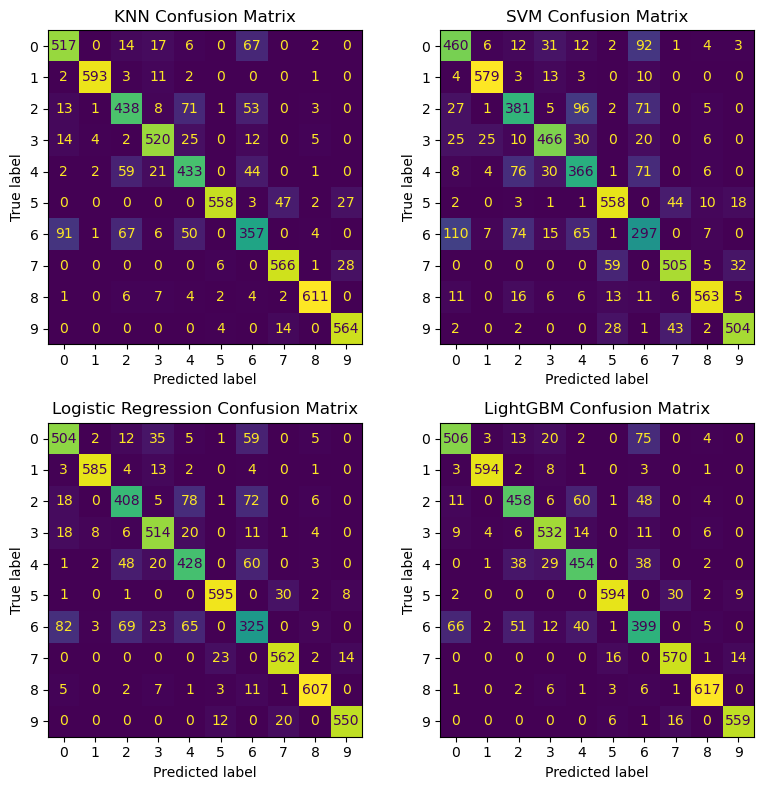

In [33]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 创建 2x2 的子图

ConfusionMatrixDisplay(cm_knn).plot(ax=axs[0, 0], colorbar=False)
axs[0, 0].set_title('KNN Confusion Matrix')

ConfusionMatrixDisplay(cm_svm).plot(ax=axs[0, 1], colorbar=False)
axs[0, 1].set_title('SVM Confusion Matrix')

ConfusionMatrixDisplay(cm_logistic).plot(ax=axs[1, 0], colorbar=False)
axs[1, 0].set_title('Logistic Regression Confusion Matrix')

ConfusionMatrixDisplay(cm_lgb).plot(ax=axs[1, 1], colorbar=False)
axs[1, 1].set_title('LightGBM Confusion Matrix')

plt.tight_layout()
plt.show()

## 5 The Best Classifier

Conclude the best classifier

In [ ]:
"""
records 15/9/24

Best parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.09218530252203186),
('max_depth', 7), ('min_data_in_leaf', 39), ('n_estimators', 476), ('num_leaves', 147),
('subsample', 0.9043547509490489)])

Best parameters: OrderedDict([('device', 'gpu'), ('learning_rate', 0.2), ('max_depth', 6),
('min_data_in_leaf', 30), ('n_estimators', 500), ('num_leaves', 100)])
Best score: 0.8806333333333333
"""
best_model = lgb.LGBMClassifier(n_estimators= 500,
                                max_depth= 7,
                                learning_rate= 0.2,
                                num_leaves= 100
                               )
best_model.fit(X_train_pca, y_train)
output = best_model.predict(X_test_pca)
# There's still room for improvement

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 72
[LightGBM] [Info] Start training from score -2.317022
[LightGBM] [Info] Start training from score -2.288682
[LightGBM] [Info] Start training from score -2.307263
[LightGBM] [Info] Start training from score -2.329271
[LightGBM] [Info] Start training from score -2.311290
[LightGBM] [Info] Start training from score -2.306593
[LightGBM] [Info] Start training from score -2.276917
[LightGBM] [Info] Start training from score -2.298593
[LightGBM] [Info] Start training from score -2.296934
[LightGBM] [Info] Start training from score -2.294286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

## 6 Output

In [45]:
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('./test_output.csv', sep=",", float_format='%d',index_label="id")

In [46]:
df = pd.read_csv('./test_output.csv')
df.head()

,id,label
0,0,3
1,1,7
2,2,3
3,3,0
4,4,9
